In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from numpy import median
import geopandas as gpd
#import contextily as cx
import plotly.express as px
import plotly.graph_objects as go
import string
import random
import numpy as np
import re
pd.set_option('display.max_rows', 50)

In [13]:
file_path = '/Users/franpontin/OneDrive - University of Leeds/CDRC/Projects/IGD/Analysis/product_data/'


In [3]:
def progress(df):
  #gives progress on EW calssificaiton
   print('N left to classify:',len(df.loc[df['Eatwell_Segment']=='Not Food',:]),
      '(Percentage classified =', 
      np.round(100-len(df.loc[df['Eatwell_Segment']=='Not Food',:])/len(df)*100,2), '%)')


In [18]:
def match_to_EW(df, list_of_columns):
    df[list_of_columns] =df[list_of_columns].astype('string')
    n=len(list_of_columns)
    ewList =['EW_' + x for x in list(map(str, list(range(0, n))))]
    df[ewList]=np.nan
    for i in range(len(ew_cat_wordLists)):
        wordList = ew_cat_wordLists[i]
        print(i+1, 'categories matched of', len(ew_cat_wordLists)) 
        for word in wordList:
            for j in range(len(w_segList)):
            # find where there is a word to macth, 
            # and it has not yet been matched in another cat (order of cat names important)
            # match the word to the word list and assign EW cat to word
                        df.loc[(df[w_segList[j]].notnull())&
                        (~df[ewList[j]].notnull())&
                        (df[w_segList[j]].str.contains(word, case=False, )),#flags=re.IGNORECASE, regex=True
                        ewList[j]] = ew_cat[i]
    df['nunique_EW']=df[ewList].apply(pd.Series.nunique, axis=1)
    #example['EW_multi_cats'] =example[['EW_0','EW_1','EW_2','EW_3','EW_4','EW_5','EW_6','EW_7','EW_8','EW_9','EW_10','EW_11','EW_12']].fillna("").astype(str).fillna("").apply(lambda x: ' '.join(x), axis=1).fillna("")
    df['EW_multi_cats'] =df[ewList].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
    df['total_seg_matched']=df[ewList].count(axis=1)  
    mode_n =df[['EW_0','EW_1','EW_2','EW_3','EW_4','EW_5','EW_6']].mode(axis=1).shape[1]
    modeList =['mode_' + x for x in list(map(str, list(range(1, mode_n+1))))]
    df[modeList] =df[ewList].mode(axis=1)
    df['Eatwell_Segment'] = 'Not Food'

In [21]:
def assign_EW(df, conditions, confidence_val, confidence_scale, match_detail, ew_cat):
    print('N='+str(len(df.loc[conditions,:])))
    df.loc[conditions, 'class_confidence_calc']=confidence_val
    df.loc[conditions, 'class_confidence']= confidence_scale
    df.loc[conditions, 'match_detail']= match_detail
    df.loc[conditions&(df['Eatwell_Segment']=='Not Food'),'Eatwell_Segment'] = ew_cat
    print('Match conditions:',match_detail)
    progress(df)
    

In [6]:
# def mismatch(df, new_col,col_1,col_2):
#     # look at cases where there are two different fat values provided
#     df.loc[(df[col_1]!=0)&(df[col_2]!=0)&(df[col_1]!=df[col_2]),new_col] ='mismatch'
#     # look at where no fat values provided
#     df.loc[(df[col_1]==0)&(df[col_2]==0),new_col] = 'No data'
#     # label where fat valeus are available
#     df.loc[(df[col_1]!=0)&(df[col_2]==0),new_col] = 'Available OB'
#     df.loc[(df[col_1]==0)&(df[col_2]!=0),new_col] = 'Available Brand'
#     df.loc[(df[col_1]!=0)&(df[col_2]!=0)&(df[col_1]==df[col_2]),new_col] = 'Available matched OB and Brand'
#     print(df[new_col].value_counts())

In [7]:
def mismatch(df, new_col,col_1,col_2):
    # look at cases where there are two different fat values provided
    df.loc[(~df[col_1].isna())&(~df[col_2].isna())&(df[col_1]!=df[col_2]),new_col] ='mismatch'
    # look at where no fat values provided
    df.loc[(df[col_1].isna())&(df[col_2].isna()),new_col] = 'No data'
    # label where fat valeus are available
    df.loc[(~df[col_1].isna())&(df[col_2].isna()),new_col] = 'Available OB'
    df.loc[(df[col_1].isna())&(~df[col_2].isna()),new_col] = 'Available Brand'
    df.loc[(~df[col_1].isna())&(~df[col_2].isna())&(df[col_1]==df[col_2]),new_col] = 'Available matched OB and Brand'
    print(df[new_col].value_counts())

In [14]:
df = pd.read_csv(file_path+'product_data.csv')
veg_list =pd.read_csv(file_path+'veg_list.csv',index_col=0)

veg_list =list(veg_list['name'])

/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (1,4,5,6,7,8,9,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,48,51,52,53,54,56,57,58,60,61,64,66,68,88,89,90,93,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
# Define products in each EW category

ew_fnv = veg_list+['courgette','dudhi','mooli', 'gourd','melon','currants', 'sultanas','swede','veg',
                   'fruit','gherkin','pickle','olives']
ew_car = ['bread','cereal','flour','pasta','pastry','potato','rolls',r'\brice\b',
          'waffles','zwieback', 'muffin', 'teff', 'bagel', r'\bcorn\b', 'spaghetti',
          'whole wheat', 'crackers', 'noodles', 'wheat', 'couscous','cous cous', 'tortilla',
          'nann','taco','pitta','wrap','chapati','chappatti', 'chapatti','sourdough',r'\bpave\b','boule','bloomer','paratha',
          'bao','cassava','naan','porridge','museli', 'muesli','baguette','quinoa','ciabatta',r'\broti\b',
          'sourdough', 'baps', 'brioche','pennoni', 'loaf','fusilli','macaroni','focaccia'] # zwieback is carb or disc? doesn't matter for this tho

ew_ptn = ['beef','chicken','domestic eggs', 'lamb','fish','frankfurter',r'\bham\b',
          'liver loaf','meat','nut','pork','sausage','turkey', 'crustaceans',
          'bean', 'chickpea', 'veal','poultry', 'steak', 'neck', 'mince',
         'fillet', 'loin', 'ostrich', 'egg', 'mollusk', 'emu', 'goose', 'duck',
          'Goat', 'lentils', 'marrow', 'flesh', 'tofu','beancurd', 'prawn', 'hummus', 'houmous',
         'haddock','salmon',r'\bcod\b','capers','tuna','breast','lobster','thighs','drumstick',
          'prosciutto','wagyu','joint', 'quorn', 'bacon', 'brisket','burger','almonds', 
          r'\bnuts\b','pistachios','pecans','butter beans','rotisserie','mortadella','kala chana',
         'liver','pig in blanket','seafood'] # marrow very fatty

ew_oil = ['butter','margarine',r'\boil\b', 'lard','spreads','vegetable oil', 'sunfower oil']
ew_dai = ['milk','whole milk','butter milk','cream','cheese','curd','yogurt', 'yoghurt','shortening',
          r'\bmilk alternatives\b', r'\blactose free drinks\b', r'\boat & nut drinks\b','kefir','cheesy',
          'brie','mozzerella','mozzarella','cheesy single', 'cheddar', 'gloucester','leicester','soya','halloumi',
          'wensleydale','coconut milk','stilton', 'paneer','feta','Lactofree','fraiche']

ew_dis = ['candy','cake','sweetener','chocolate','choc','dessert','ice cream',
          'mustard','mayonnaise','salty snack','pudding powder','popcorn',
          'sweet spreads','syrup','sugar','jam','ketchup', 'fudge', 'cocoa',
          'snack products','sauce', 'cookie','pastries', 'pudding', 'pancake',
         'candies', 'wafer', 'fries', 'crumpets', 'muffins', 'crisps','jam','condiments',
          'gravy', 'yeast', 'marmalade', 'conserve','caramel','brownie','bakewell','profiterole',
          'Soreen','chips','biscuit', 'scone', 'snack', 'marzipan','toffee','custard',r'\bicing\b',
          'jelly','stollen','poppadom', 'poppadum','tiramisu','croissant','macaroon','mringue','cheesecake','salad cream',
         r'\bpain au rasin\b','shortbread','honey','salami','cheesecake','panna cotta','sweets', 'mints', 'donner kerbab',
          'hash brown',r'\bhot cross bun\b','pick and mix','sharing bag','crouton', 'hot cross bun','bakery',
          'dressing','flapjack','swiss roll','pain au raisin','mallow','preserve','trifle']

ew_alc = ['brandy','beer','wine','prosecco','liqueur','liquor',r'\brum\b','whisky', 'cocktail',
          'Liqueur', r'\bgin\b','sauvignon','ABV','%','daiquiry','martini','cava','rioja','pilsner','sherry','cider',r'\bport\b']
ew_com = ['nut/prunes','soup','Instant food products',r'\bfrozen meal\b', 'pizza', 'lasagna',
          'lasagne','pie', 'burito','pakora','sandwich', 'ready meal', r'\noodle pots\b',
          'haggis','takeaway', 'meal', 'curry','balti','masala','quiche',r'\bpate\b','bolognese',
          'bolognaise','carbonara','platter','gyoza', 'coleslaw','pasta bake','granola','sping roll',
          'scampi','croquette','sandwich','party food','chilli con carne','hot dog','kmoussaka','enchilada',
          'fajita',r'\bstir fry\b', 'katsu','salsa']

# Add cateogry for infant formula etc. (not incl;uded in adult recommendations)
ew_inf = ['formula','babyfood', 'toddler','infant','formula']

ew_other =['seasoning', 'baking', 'spices','medical','coriander','HERBS & SPICES',  r'\bice cube\b', 'salt']
# add beverage cat.

ew_bev = ['juice', 'beverage', 'fizzy drink', 'cola', r'\bcoke\b',r'\bminneral water\b', 'mineral','drink',
          'coffee', 'sparkling water','tea', 'lucozade','decaf','tonic','soda','Kombucha', 'bottle', r'\bcan\b',
          'Sarsaparilla','smoothie','latte', r'\bginger ale\b', 'water', r'\balcohol free\b', 'ginger ale']

# add exclude - food items without significant nutritional contribution in terms of eat well
# e.g. spices, herbs, make sure to check salt and sugar)

#ew_exc = []

ew_cat = ['Fruit & Veg', 'Starchy Carbs', 'Protein', 'Oils & Spreads', 'Dairy & Alt.',
          'Discretionary', 'Alcoholic Bev.','Composite', 'Infant', 'Non Alcoholic Bev.', 'Other']

ew_cat_wordLists = [ew_fnv,ew_car,ew_ptn,ew_oil,ew_dai,ew_dis,ew_alc,ew_com, ew_inf, ew_bev, ew_other]



In [19]:
w_segList =['Shelf_1','Shelf_2', 'Shelf_3', 'Shelf_4', 'Shelf_5','MDSE Subcategory Name','MDSE Category Name']
match_to_EW(df, w_segList)

1 categories matched of 11
2 categories matched of 11
3 categories matched of 11
4 categories matched of 11
5 categories matched of 11
6 categories matched of 11
7 categories matched of 11
8 categories matched of 11
9 categories matched of 11
10 categories matched of 11
11 categories matched of 11


In [22]:
print('Percentage with no match on inital join: '+str(round(len(df.loc[df['total_seg_matched']<1])/len(df)*100,2))+"%")

Percentage with no match on inital join: 5.12%


In [23]:
assign_EW(df=df, 
          conditions=((df['nunique_EW']==1 )& (df['total_seg_matched']>1)), 
          confidence_val=1.00, 
          confidence_scale='High',
          match_detail='Product name matched to single EW category more than once',
          ew_cat=df['mode_1'])

N=9162
Match conditions: Product name matched to single EW category more than once
N left to classify: 11481 (Percentage classified = 44.38 %)


In [26]:
assign_EW(df=df, 
          conditions=((df['nunique_EW']==1 )& (df['total_seg_matched']==1)), 
          confidence_val=1.00, 
          confidence_scale='Fairly High',
          match_detail='Product name matched to single EW category once',
          ew_cat=df['mode_1'])

N=3453
Match conditions: Product name matched to single EW category once
N left to classify: 3819 (Percentage classified = 81.5 %)


In [27]:
assign_EW(df=df, 
          conditions=((df['nunique_EW']>=2)&
            (df['mode_2'].isna())&
            (df['mode_3'].isna())&
            (df['Eatwell_Segment']=='Not Food')),
          confidence_val=df['nunique_EW']/df['total_seg_matched'], 
          confidence_scale='Good',
          match_detail='Product name matched to multiple EW categories, most common and first cateogry matched are the same',
          ew_cat=df['mode_1'])

N=0
Match conditions: Product name matched to multiple EW categories, most common and first cateogry matched are the same
N left to classify: 3819 (Percentage classified = 81.5 %)


In [28]:
df['match_detail'].value_counts()

Product name matched to single EW category more than once                                              9162
Product name matched to multiple EW categories, most common and first cateogry matched are the same    4209
Product name matched to single EW category once                                                        3453
Name: match_detail, dtype: int64

In [29]:
assign_EW(df=df, 
          conditions=((df['total_seg_matched']==2)&(~df['mode_2'].isna())&(df['Eatwell_Segment']=='Not Food')&
                          # and one of those EW cats is composite class as composite
                          (df['EW_multi_cats'].str.contains('Composite', case=False))),
          confidence_val=1/df['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such ",
          ew_cat='Composite')

N=240
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such 
N left to classify: 3579 (Percentage classified = 82.66 %)


In [30]:
assign_EW(df=df, 
          conditions=(df['total_seg_matched']==2)&(~df['mode_2'].isna())&(df['Eatwell_Segment']=='Not Food')&
       # if one of the EW cats mathced is 'Discretioanry' then class as discreitoanry
       (df['EW_multi_cats'].str.contains('Discretionary', case=False)),
          confidence_val=1/df['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such ",
          ew_cat='Discretionary')

N=1293
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such 
N left to classify: 2286 (Percentage classified = 88.93 %)


### For unmatched products split the product description and classify each component of the product description

In [36]:
print ('For the remaining', df.loc[(df['Eatwell_Segment']=='Not Food'),:].shape[0], 'products split the product descirption and match based on indvidual components of the description')

For the remaining 2286 products split the product descirption and match based on indvidual components of the description


In [38]:
split_name =df.loc[(df['Eatwell_Segment']=='Not Food'),'name'].str.split(' ', expand=True)
split_name.columns =['w0','w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11',
                     'w12','w13','w14','w15']
split_name =split_name.merge(df[['name','Retailer Barcode']], left_index=True, right_index=True, how='left')
w_segList =['w0','w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11',
                     'w12','w13','w14','w15']

match_to_EW(split_name, w_segList)

1 categories matched of 11
2 categories matched of 11
3 categories matched of 11
4 categories matched of 11
5 categories matched of 11
6 categories matched of 11
7 categories matched of 11
8 categories matched of 11
9 categories matched of 11
10 categories matched of 11
11 categories matched of 11


In [39]:
assign_EW(df=split_name, 
          conditions=((split_name['nunique_EW']==1 )& (split_name['total_seg_matched']>1)), 
          confidence_val=1.00, 
          confidence_scale='High',
          match_detail='Product name matched to single EW category more than once',
          ew_cat=df['mode_1'])

N=244
Match conditions: Product name matched to single EW category more than once
N left to classify: 2042 (Percentage classified = 10.67 %)


In [40]:
assign_EW(df=split_name, 
          conditions=((split_name['nunique_EW']==1 )& (split_name['total_seg_matched']==1)), 
          confidence_val=1.00, 
          confidence_scale='Fairly High',
          match_detail='Product name matched to single EW category once',
          ew_cat=df['mode_1'])

N=1005
Match conditions: Product name matched to single EW category once
N left to classify: 1037 (Percentage classified = 54.64 %)


In [41]:
assign_EW(df=split_name, 
          conditions=((split_name['nunique_EW']>=2)&
            (split_name['mode_2'].isna())&
            (split_name['mode_3'].isna())&
            (split_name['Eatwell_Segment']=='Not Food')),
          confidence_val=split_name['nunique_EW']/split_name['total_seg_matched'], 
          confidence_scale='Good',
          match_detail='Product name matched to multiple EW categories, most common and first cateogry matched are the same',
          ew_cat=split_name['mode_1'])

N=205
Match conditions: Product name matched to multiple EW categories, most common and first cateogry matched are the same
N left to classify: 832 (Percentage classified = 63.6 %)


In [42]:
assign_EW(df=split_name, 
          conditions=((split_name['total_seg_matched']==2)&(~split_name['mode_2'].isna())&(df['Eatwell_Segment']=='Not Food')&
                          # and one of those EW cats is composite class as composite
                          (split_name['EW_multi_cats'].str.contains('Composite', case=False))),
          confidence_val=1/split_name['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such ",
          ew_cat='Composite')

N=90
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such 
N left to classify: 742 (Percentage classified = 67.54 %)


In [43]:
assign_EW(df=split_name, 
          conditions=(split_name['total_seg_matched']==2)&(~split_name['mode_2'].isna())&(split_name['Eatwell_Segment']=='Not Food')&
       # if one of the EW cats mathced is 'Discretioanry' then class as discreitoanry
       (split_name['EW_multi_cats'].str.contains('Discretionary', case=False)),
          confidence_val=1/split_name['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such ",
          ew_cat='Discretionary')


N=189
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such 
N left to classify: 553 (Percentage classified = 75.81 %)


### Combine product description matched data with disaggregated matches 

In [46]:
new_df =df
new_df = new_df.drop(split_name.index)
new_df =pd.concat([new_df, split_name], axis=0)
new_df



,Unnamed: 0,Retailer Product Name,Retailer Barcode,Retailer Identifier Additional,Retailer Shelf,Shelf_1,Shelf_2,Shelf_3,Shelf_4,Shelf_5,...,EW_7,EW_8,EW_9,EW_10,EW_11,EW_12,EW_13,EW_14,EW_15,mode_4
0,0.0,Britvic Indian Tonic Water 850ml,5.010000e+12,7173266.0,"asda > beer, wine & spirits > spirits > mixers...",asda,"beer, wine & spirits",spirits,mixers & tonic water,tonic water,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,Britvic Indian Tonic Water Low Calorie 24x125,5.010000e+12,7185866.0,"asda > beer, wine & spirits > spirits > mixers...",asda,"beer, wine & spirits",spirits,mixers & tonic water,tonic water,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,Britvic Indian Tonic Water 24x125,5.010000e+12,7185868.0,"asda > beer, wine & spirits > spirits > mixers...",asda,"beer, wine & spirits",spirits,mixers & tonic water,tonic water,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,Greene King Abbot Ale 500ml,5.010000e+12,628536.0,"asda > beer, wine & spirits > beer, lager & al...",asda,"beer, wine & spirits","beer, lager & ales",ale & bitter,ale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,Greene King Abbot Ale 4x500,5.010000e+12,539003.0,"asda > beer, wine & spirits > beer, lager & al...",asda,"beer, wine & spirits","beer, lager & ales",ale & bitter,ale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20565,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20566,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20567,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20593,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
assign_EW(df=new_df, 
          conditions=((new_df['name'].str.contains('flour', case=False))&(new_df['Eatwell_Segment']=='Not Food')),
          confidence_val= 1.00,
          confidence_scale='Fairly High',
          match_detail="Product name contains flour so classed as starchy carb.",
          ew_cat =  'Starchy Carbs')
          

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['nunique_EW']==2) 
               &(new_df['EW_multi_cats']=='Fruit & Veg, Non Alcoholic Bev.')
               &(new_df['name'].str.contains('in '))), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.', 
          ew_cat='Fruit & Veg')
assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['nunique_EW']==2) 
               &(new_df['EW_multi_cats']=='Fruit & Veg, Non Alcoholic Bev.')
               &(~new_df['name'].str.contains('in '))), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.', 
          ew_cat='Non Alcoholic Bev.')            

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&
                                  (new_df['nunique_EW']==2)&
                                  (new_df['EW_multi_cats']=='Fruit & Veg, Starchy Carbs')), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite', 
          ew_cat='Starchy Carbs')    

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&
                                  (new_df['nunique_EW']==2)&
                                  (new_df['EW_multi_cats']=='Protein, Starchy Carbs')), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite', 
          ew_cat='Starchy Carbs')    

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')& 
               (new_df['name'].str.contains('%'))), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 EW categorys, if product name contains % (alcohol) class as alcoholic bev.', 
          ew_cat='Alcoholic Bev.')   

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&
                                  (new_df['nunique_EW']==2)&
                                  (new_df['name'].str.contains('yogurt|yoghurt',case=False))), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 EW categorys, if product name contains yoghurt class as dairy', 
          ew_cat='Dairy & Alt.')  

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['name'].str.contains('with'))), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 EW categorys, if the name contians `with` classify as composite', 
          ew_cat='Dairy & Alt.')   

N=2
Match conditions: Product name contains flour so classed as starchy carb.
N left to classify: 551 (Percentage classified = 97.33 %)
N=13
Match conditions: Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.
N left to classify: 538 (Percentage classified = 97.39 %)
N=66
Match conditions: Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.
N left to classify: 472 (Percentage classified = 97.71 %)
N=26
Match conditions: Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite
N left to classify: 446 (Percentage classified = 97.84 %)
N=19
Match conditions: Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite
N left to classify: 427 (Percentage classified = 97.93 %)
N=9
Match conditions: Product name

In [48]:
assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['nunique_EW']>=2)), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 or more EW categorys, if not already matched classify as composite', 
          ew_cat='Composite')   



N=228
Match conditions: Product name matched to 2 or more EW categorys, if not already matched classify as composite
N left to classify: 157 (Percentage classified = 99.24 %)


In [49]:
assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['name'].str.contains(r'\bice\b', case=False))), 
          confidence_val=0.9, 
          confidence_scale='Good', 
          match_detail= 'Product name contians `ice` classify as other', 
          ew_cat='Other')   

N=3
Match conditions: Product name contians `ice` classify as other
N left to classify: 154 (Percentage classified = 99.25 %)


<AxesSubplot:>

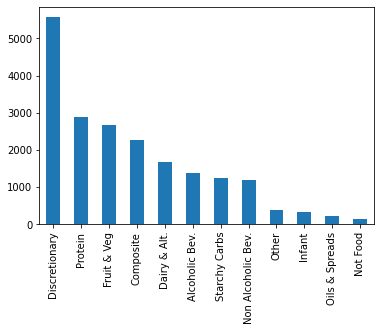

In [50]:
new_df['Eatwell_Segment'].value_counts().plot(kind='bar')

In [51]:
Brand_data= ['Carbohydrate_g','Energy_kj','Fat_g','Fibre_g','Protein_g','Salt_g','Saturates_g','Sugars_g']
OB_data = ['Carbohydrate/100g','kJ/100g', 'Fat/100g','Fibre/100g','Protein/100g','Salt/100g','Saturated fat/100g','Sugar/100g']
mismatch_cols = ['Carbohydrate_data','Energy_data','Fat_data','Fibre_data','Protein_data', 'Salt_data','Saturated_fat_data','Sugar_data']

#new_df[Brand_data]=new_df[Brand_data].apply(pd.to_numeric, errors='coerce').replace(np.nan,0)
#new_df[OB_data]=new_df[OB_data].apply(pd.to_numeric, errors='coerce').replace(np.nan,0)

In [52]:
for i,j,k in zip(mismatch_cols,Brand_data,OB_data):
    mismatch(new_df,i,j,k)

Available OB       10843
Available Brand     4994
No data             4409
mismatch             397
Name: Carbohydrate_data, dtype: int64
Available OB       10991
Available Brand     4996
No data             4261
mismatch             395
Name: Energy_data, dtype: int64
Available OB       10757
Available Brand     4994
No data             4495
mismatch             397
Name: Fat_data, dtype: int64
Available OB       7951
No data            7301
Available Brand    4994
mismatch            397
Name: Fibre_data, dtype: int64
Available OB       10775
Available Brand     4994
No data             4477
mismatch             397
Name: Protein_data, dtype: int64
Available OB       10738
Available Brand     4994
No data             4514
mismatch             397
Name: Salt_data, dtype: int64
Available OB       10754
Available Brand     4994
No data             4498
mismatch             397
Name: Saturated_fat_data, dtype: int64
Available OB       10809
Available Brand     4994
No data             44

NEXT: get all rows containign mismatch

In [53]:
new_df['mismatch_present']=(new_df == 'mismatch').any(axis=1)

In [54]:
mismatch = new_df.loc[new_df['mismatch_present']==True,:]

In [55]:
mismatch

,Unnamed: 0,Retailer Product Name,Retailer Barcode,Retailer Identifier Additional,Retailer Shelf,Shelf_1,Shelf_2,Shelf_3,Shelf_4,Shelf_5,...,mode_4,Carbohydrate_data,Energy_data,Fat_data,Fibre_data,Protein_data,Salt_data,Saturated_fat_data,Sugar_data,mismatch_present
13981,13981.0,ASDA Baked Beans in Tomato Sauce 4x410g,21045639.0,21897.0,asda > food cupboard > tinned food > baked beans,asda,food cupboard,tinned food,baked beans,<NA>,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
13982,13982.0,ASDA Baked Beans in Tomato Sauce 4x410g,21045639.0,21897.0,asda > food cupboard > tinned food > baked beans,asda,food cupboard,tinned food,baked beans,<NA>,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
13984,13984.0,ASDA Soft Scoop Cornish Vanilla Ice Cream 2l,20401016.0,443462.0,asda > frozen food > ice cream parlour > view ...,asda,frozen food,ice cream parlour,view all ice cream parlour,<NA>,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
13985,13985.0,ASDA Soft Scoop Cornish Vanilla Ice Cream 2l,20401016.0,443462.0,asda > frozen food > ice cream parlour > view ...,asda,frozen food,ice cream parlour,view all ice cream parlour,<NA>,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
13986,13986.0,ASDA Soft Scoop Cornish Vanilla Ice Cream 2l,20401016.0,443462.0,asda > frozen food > ice cream parlour > view ...,asda,frozen food,ice cream parlour,view all ice cream parlour,<NA>,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14557,14557.0,ASDA Wheat Bisks Cereal 48pk,21115202.0,217410.0,asda > vegan & plant based > vegan food > vega...,asda,vegan & plant based,vegan food,vegan food cupboard,vegan cereal,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
14558,14558.0,ASDA Pacific Pink Salmon 213g,21081170.0,874271.0,asda > food cupboard > tinned food > tinned fi...,asda,food cupboard,tinned food,tinned fish,salmon,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
14559,14559.0,ASDA Pacific Pink Salmon 418g,21081187.0,205219.0,asda > food cupboard > tinned food > tinned fi...,asda,food cupboard,tinned food,tinned fish,salmon,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True
14560,14560.0,ASDA Pacific Red Salmon 105g,21081194.0,205230.0,asda > food cupboard > tinned food > tinned fi...,asda,food cupboard,tinned food,tinned fish,salmon,...,NaN,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,mismatch,True


In [34]:
new_df.loc[new_df['mismatch_present']==True,:].to_csv('mismatch.csv')

In [35]:
mismatch_percent_diff = ['Carbohydrate_percent_diff','Energy_percent_diff','Fat_percent_diff','Fibre_percent_diff','Protein_percent_diff', 'Salt_percent_diff','Saturated_fat_percent_diff','Sugar_percent_diff']

In [36]:
mismatch[OB_data].dtypes

Carbohydrate/100g     float64
kJ/100g               float64
Fat/100g              float64
Fibre/100g            float64
Protein/100g          float64
Salt/100g             float64
Saturated fat/100g    float64
Sugar/100g            float64
dtype: object

In [37]:
mismatch[k]

13981     4.2
13982     4.2
13984    15.2
13985    15.2
13986    15.2
         ... 
14557     4.4
14558     0.0
14559     0.0
14560     0.0
14561     0.0
Name: Sugar/100g, Length: 397, dtype: float64

In [38]:
mismatch[i].apply(pd.to_numeric, errors='coerce')

13981   NaN
13982   NaN
13984   NaN
13985   NaN
13986   NaN
         ..
14557   NaN
14558   NaN
14559   NaN
14560   NaN
14561   NaN
Name: Sugar_data, Length: 397, dtype: float64

In [39]:
for i,j,k in zip(Brand_data,OB_data, mismatch_percent_diff):
    mismatch[k]=(mismatch[i].apply(pd.to_numeric, errors='coerce'))-mismatch[j].apply(pd.to_numeric, errors='coerce'))/(mismatch[i].apply(pd.to_numeric, errors='coerce'))*100
    #print(mismatch[k])
    print(i,j,k)

SyntaxError: invalid syntax (<ipython-input-39-e38c637106ee>, line 2)

In [ ]:
mismatch[mismatch_percent_diff]

In [ ]:
# look for producst with a >% disaprity between Ob and brand data
for i in mismatch[mismatch_percent_diff].columns:
   large_mismatch =mismatch.loc[mismatch[i]>=5,:]

In [ ]:
large_mismatch.to_csv('products_with_nutriton_data_disparity.csv')

Look at values with missing nutrition data

In [ ]:
new_df['missing_nutrition_data']=(new_df == 'No data').any(axis=1)

In [ ]:
list(new_df)

In [ ]:
new_df.loc[new_df['missing_nutrition_data']==True, 'Eatwell_Segment'].value_counts()

In [ ]:
ew_cat

In [ ]:
new_df.loc[new_df['Eatwell_Segment']=='Non Alcoholic Bev.','Protein_g'].hist()

In [ ]:
new_df["kcal/100g"]

In [ ]:
fig = px.histogram(new_df, x="kcal/100g", y="Protein_g", color="Eatwell_Segment", marginal="rug",
                   ) #hover_data selects the variable which appears when hovering over the data points
fig.update_xaxes(fixedrange=False)
fig.show()
# saves as sharable html (could add straight to website)
#fig.write_html("/Users/franpontin/OneDrive - University of Leeds/CDRC/Projects/IGD/Analysis/interactive_plots/calorie_protein_hist_eatwell.html")



In [ ]:
list(new_df)

In [ ]:
temp =pd.DataFrame(new_df.loc[new_df['missing_nutrition_data']==True,:].groupby('Eatwell_Segment')['fat_data'].value_counts()).rename(columns={'fat_data': 'count'}).reset_index()

In [ ]:
pd.pivot_table(data=pd.DataFrame(new_df.loc[new_df['missing_nutrition_data']==True,:].groupby('Eatwell_Segment')['fat_data'].value_counts()).rename(columns={'fat_data': 'count'}).reset_index(),values='count', index='Eatwell_Segment', columns='fat_data')

In [ ]:
new_df.loc[new_df['missing_nutrition_data']==True,:].groupby('Eatwell_Segment')['fat_data',
 'Carbohydrate_data',
 'Energy_data',
 'Fat_data',
 'Fibre_data',
 'Protein_data',
 'Salt_data',
 'Saturated_fat_data',
 'Sugar_data'].value_counts()

In [ ]:
new_df.loc[new_df['mismatch_present']==True,]

Look at rows with datya missmatch

In [ ]:
list(new_df)